<a href="https://colab.research.google.com/github/padmarathii/lol2/blob/master/Copy_of_Malicious_URL_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the Libraries

In [ ]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Loading the Dataset

In [ ]:
data = pd.read_csv('gdrive/MyDrive/ext/malicious_phish.csv')
print(data.shape)
data.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
data.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

Feature Engineering

In [ ]:
# Use of IP or not in domain
import re

def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
data['use_of_ip'] = data['url'].apply(lambda i: having_ip_address(i))

In [ ]:
# Abnormal URL

from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

In [ ]:
# Google Index

# pip install googlesearch-python

from googlesearch import search

def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
data['google_index'] = data['url'].apply(lambda i: google_index(i))

In [ ]:
# Count "."

def count_dot(url):
    count_dot = url.count('.')
    return count_dot

data['count.'] = data['url'].apply(lambda i: count_dot(i))

# Count "www"

def count_www(url):
    url.count('www')
    return url.count('www')

data['count-www'] = data['url'].apply(lambda i: count_www(i))

# Count "@"

def count_atrate(url):
     
    return url.count('@')

data['count@'] = data['url'].apply(lambda i: count_atrate(i))

# Count "number of directories"

def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

data['count_dir'] = data['url'].apply(lambda i: no_of_dir(i))

# Count "number of embeded domains"
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

data['count_embed_domian'] = data['url'].apply(lambda i: no_of_embed(i))

# Count "https"

def count_https(url):
    return url.count('https')

data['count-https'] = data['url'].apply(lambda i : count_https(i))

# Count "http"

def count_http(url):
    return url.count('http')

data['count-http'] = data['url'].apply(lambda i : count_http(i))

# Count "%"

def count_per(url):
    return url.count('%')

data['count%'] = data['url'].apply(lambda i : count_per(i))

# Count "?"

def count_ques(url):
    return url.count('?')

data['count?'] = data['url'].apply(lambda i: count_ques(i))

# Count "-"
def count_hyphen(url):
    return url.count('-')

data['count-'] = data['url'].apply(lambda i: count_hyphen(i))

# Count "="
def count_equal(url):
    return url.count('=')

data['count='] = data['url'].apply(lambda i: count_equal(i))

# Count "Digits"

def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


data['count-digits']= data['url'].apply(lambda i: digit_count(i))

# Count "Letters"

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

data['count-letters']= data['url'].apply(lambda i: letter_count(i))

In [ ]:
# Suspicious words in URL

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
data['sus_url'] = data['url'].apply(lambda i: suspicious_words(i))


In [ ]:
# Short URL

def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
data['short_url'] = data['url'].apply(lambda i: shortening_service(i))

In [ ]:
# Length of URL

def url_length(url):
  return len(str(url))
data['url_length'] = data['url'].apply(lambda i: url_length(i))

In [ ]:
# Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

data['hostname_length'] = data['url'].apply(lambda i: hostname_length(i))

In [ ]:
# First Directory Length

def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

data['fd_length'] = data['url'].apply(lambda i: fd_length(i))


In [ ]:
pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Length of Top-level Domains

from urllib.parse import urlparse
from tld import get_tld
import os.path
data['tld'] = data['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

data['tld_length'] = data['tld'].apply(lambda i: tld_length(i))

In [ ]:
data.shape

(651191, 25)

In [ ]:
data.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count=,count-digits,count-letters,sus_url,short_url,url_length,hostname_length,fd_length,tld,tld_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,13,0,0,16,0,0,None,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,1,29,0,0,35,0,5,None,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,1,25,0,0,31,0,7,None,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,4,7,63,0,0,88,21,9,be,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,3,22,199,0,0,235,23,9,net,3


## Exploratory Data Analysis

1. Distribution of use_of_ip

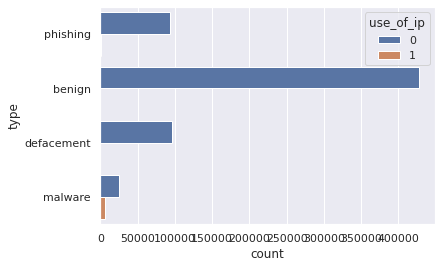

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=data, hue="use_of_ip")

2. Distribution of Abnormal URL

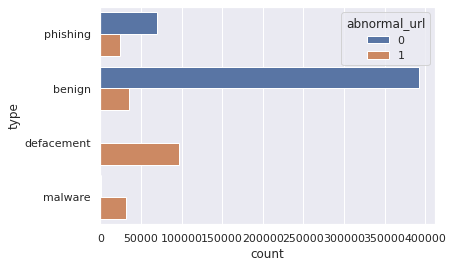

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=data, hue="abnormal_url")

3. Distribution of Google Index

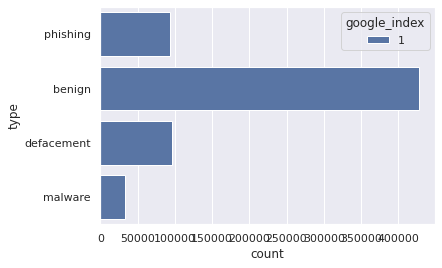

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=data, hue="google_index")

4. Distribution of Short URL

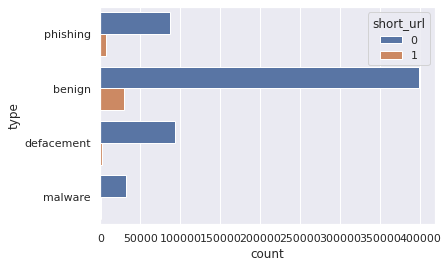

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=data, hue="short_url")

5. Distribution of Suspicious URL

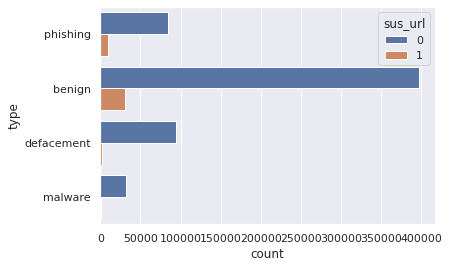

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=data, hue="sus_url")

6. Distribution of count of [.] dot

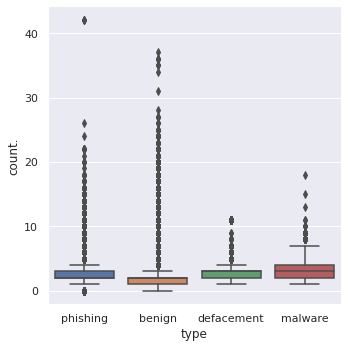

In [ ]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count.", kind="box", data=data)

7. Distribution of count-www

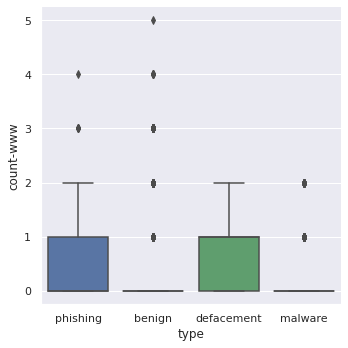

In [ ]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-www", kind="box", data=data)

8. Distribution of count @

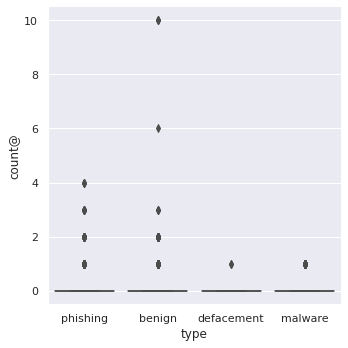

In [ ]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count@", kind="box", data=data)

9. Distribution of count_dir

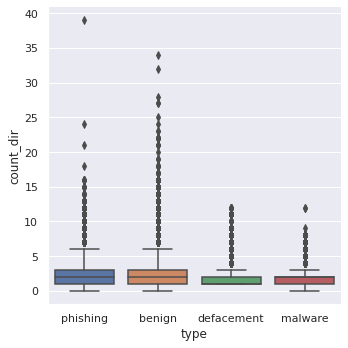

In [ ]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir", kind="box", data=data)

10. Distribution of hostname length

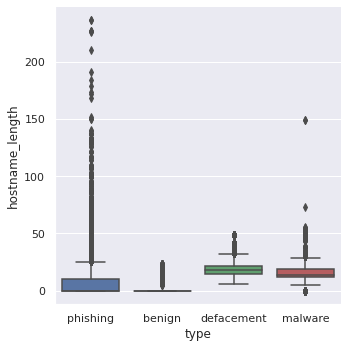

In [ ]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=data)

11. Distribution of First Directory Length

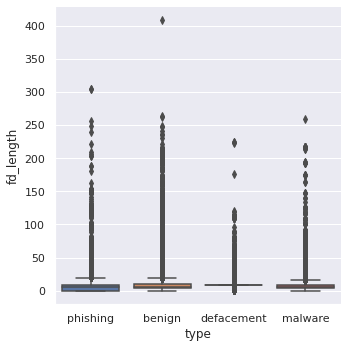

In [ ]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="fd_length", kind="box", data=data)

12. Distribution of Top-level Domain length

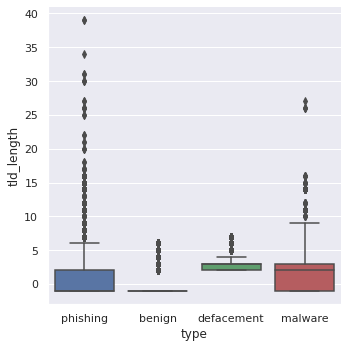

In [ ]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="tld_length", kind="box", data=data)

## Target Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
data["type_code"] = lb_make.fit_transform(data["type"])
data["type_code"].value_counts()

0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

### Creation of Feature and Target

In [ ]:
# Predictor Variables
# filtering out google_index as it has only 1 value
X = data[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = data['type_code']

In [ ]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


In [ ]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters'],
      dtype='object')

### Splitting the training and testing data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=5)

### Model Building

1. Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.94      0.96      6504
     malware       0.91      0.86      0.88     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:   0.966


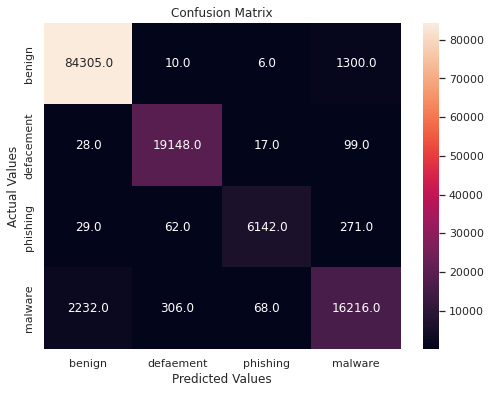

In [ ]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred_rf)
cm_data = pd.DataFrame(cm,
                       index = ['benign','defacement','phishing','malware'],
                       columns = ['benign','defaement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_data, annot=True, fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Feature Importance

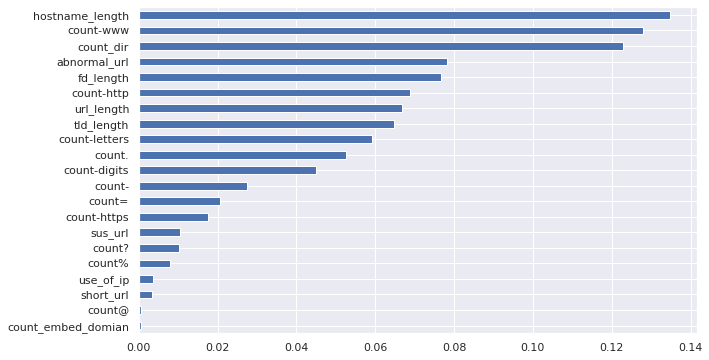

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

2. Light GBM Classifier

In [ ]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.97     19292
    phishing       0.96      0.89      0.92      6504
     malware       0.90      0.81      0.85     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.92      0.93    130239
weighted avg       0.95      0.96      0.95    130239

accuracy:   0.956


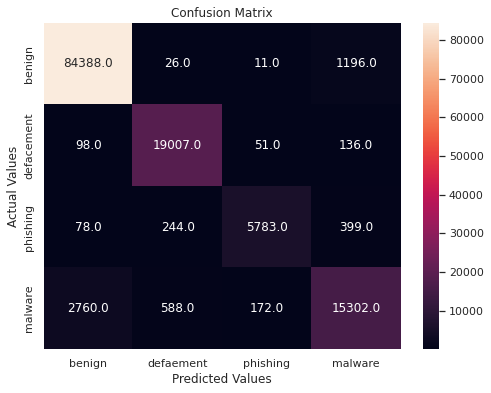

In [ ]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred_lgb)
cm_data = pd.DataFrame(cm,
                       index = ['benign','defacement','phishing','malware'],
                       columns = ['benign','defaement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_data, annot=True, fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

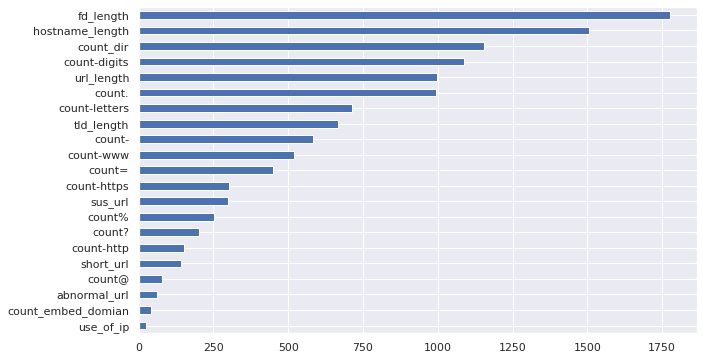

In [ ]:
# Feature Importance
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

3. XGBoost Classifier

In [ ]:
xgb_c = xgb.XGBClassifier(n_estimators= 100)
xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))


score = metrics.accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.95      0.98      0.97     85621
  defacement       0.89      0.96      0.92     19292
    phishing       0.91      0.76      0.83      6504
     malware       0.88      0.73      0.80     18822

    accuracy                           0.93    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.93      0.93      0.93    130239

accuracy:   0.933


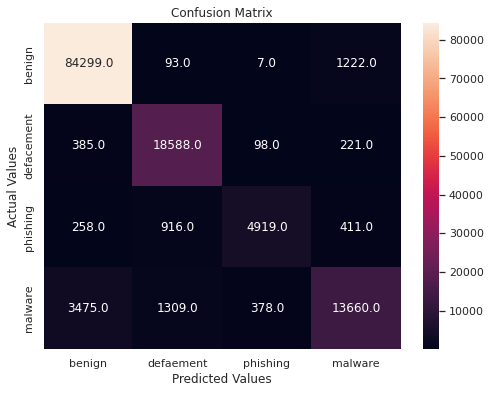

In [ ]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred_x)
cm_data = pd.DataFrame(cm,
                       index = ['benign','defacement','phishing','malware'],
                       columns = ['benign','defaement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_data, annot=True, fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

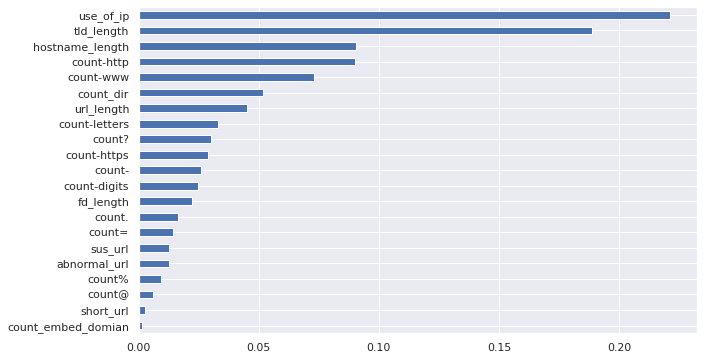

In [ ]:
# Feature Importance
feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

### Prediction

In [ ]:
def main(url):
    
    status = []
    
    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))
    
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    
    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    
    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)
      
    status.append(tld_length(tld))
    
    return status

# Predict function 

def get_prediction_from_url(test_url):
    features_test = main(test_url)
  
    features_test = np.array(features_test).reshape((1, -1))
    pred = lgb.predict(features_test)
    if int(pred[0]) == 0:
        
        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:
        
        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res
        
    elif int(pred[0]) == 3.0:
        
        res="MALWARE"
        return res


# Predicting sample raw URLs

urls = ['titaniumcorporate.co.za','en.wikipedia.org/wiki/North_Dakota']

for url in urls:
     print(get_prediction_from_url(url))

MALWARE
SAFE


In [ ]:
urls = ['https//www.seedify-finance.com/','https//facebook.com']
for url in urls:
  print(get_prediction_from_url(url))

SAFE
SAFE
